<a href="https://www.kaggle.com/code/osmanacar/telco-customer-churn?scriptVersionId=213250734" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

df = pd.read_csv('/kaggle/input/telecom-dataset/telco.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Analysis and Preparing**

In [2]:
df.shape

(7043, 21)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##############################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col, False)

        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435
##############################################
         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##############################################
            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##############################################
              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374
##############################################
                  MultipleLines      Ratio
MultipleLines                             
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##############################################
                 InternetService      Ratio
InternetSe

In [8]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.ylabel(numerical_col)
        plt.show(block=True)


for col in num_cols:
    num_summary(df, col, plot=False)


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.000,1.0000,1.00


In [10]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "TARGET_COUNT": dataframe.groupby(categorical_col)[target].count()}), end="\n\n\n")

    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)


for col in cat_cols:
    target_summary_with_cat(df, "Churn", col, plot=False)

        TARGET_MEAN  TARGET_COUNT
gender                           
Female     0.269209          3488
Male       0.261603          3555


         TARGET_MEAN  TARGET_COUNT
Partner                           
No          0.329580          3641
Yes         0.196649          3402


            TARGET_MEAN  TARGET_COUNT
Dependents                           
No             0.312791          4933
Yes            0.154502          2110


              TARGET_MEAN  TARGET_COUNT
PhoneService                           
No               0.249267           682
Yes              0.267096          6361


                  TARGET_MEAN  TARGET_COUNT
MultipleLines                              
No                   0.250442          3390
No phone service     0.249267           682
Yes                  0.286099          2971


                 TARGET_MEAN  TARGET_COUNT
InternetService                           
DSL                 0.189591          2421
Fiber optic         0.418928          3096
No        

In [11]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(dataframe.groupby(target).agg({numerical_col: ["mean", "count"]}), end="\n\n\n")
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)


for col in num_cols:
    target_summary_with_num(df, "Churn", col, plot=False)


          tenure      
            mean count
Churn                 
0      37.569965  5174
1      17.979133  1869


      MonthlyCharges      
                mean count
Churn                     
0          61.265124  5174
1          74.441332  1869




In [12]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
        
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False


In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

              n_miss  ratio
TotalCharges      11   0.16


In [14]:
df = df.dropna()

In [15]:
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [16]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col, plot=False)

        TARGET_MEAN  TARGET_COUNT
gender                           
Female     0.269595          3483
Male       0.262046          3549


         TARGET_MEAN  TARGET_COUNT
Partner                           
No          0.329761          3639
Yes         0.197171          3393


            TARGET_MEAN  TARGET_COUNT
Dependents                           
No             0.312791          4933
Yes            0.155312          2099


              TARGET_MEAN  TARGET_COUNT
PhoneService                           
No               0.250000           680
Yes              0.267475          6352


                  TARGET_MEAN  TARGET_COUNT
MultipleLines                              
No                   0.250812          3385
No phone service     0.250000           680
Yes                  0.286485          2967


                 TARGET_MEAN  TARGET_COUNT
InternetService                           
DSL                 0.189983          2416
Fiber optic         0.418928          3096
No        

# **Feature Engineering**

In [17]:
# tenure değerlerine göre customer kategorisi
df["CustomerCategory"] = pd.qcut(df["tenure"], q=3, labels=["NewCustomer", "MindTermCustomer", "LongTermCustomer"])

df.head(10)
# yaşlı olup telefon servisi kullananlar
df["SeniorInternetService"] = df.apply(lambda x: 1 if (x["SeniorCitizen"] == 0) & (x["PhoneService"] == "Yes") else 0,
                                       axis=1)
# aylık harcamayı azdan çoğa doğru 5 parçaya böldüm
df["MonthlyChargesClass"] = pd.qcut(df["MonthlyCharges"], 5, labels=["Low", "Low-Mid", "Mid", "Mid-High", "High"])

# aylık olarak en fazla güvenlik hizmeti alan kişileri 1-0 ladım
df["MonthlySecureService"] = df.apply(
    lambda x: 1 if (x["MonthlyChargesClass"] == "High") & (x[
                                                               "OnlineSecurity"] == "Yes") & (
                           x["DeviceProtection"] == "Yes") & (x["TechSupport"] == "Yes") else 0, axis=1)

# hizmet süresi ve müşteri tipi
df["TenureContract"] = df[["CustomerCategory", "Contract"]].apply(lambda x: "_".join(x), axis=1)

# aldığı servislerin toplamı
df["TotalServiceCount"] = (df[["PhoneService", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                               "TechSupport", "StreamingTV", "StreamingMovies"]] == "Yes").sum(axis=1)

# otomatik ödeme yapıp yapmadığı
df["AutoPayment"] = df["PaymentMethod"].apply(
    lambda x: 1 if x in ["Bank Transfer (automatic)", "Credit Card (automatic)"] else 0)

# telefon servisi kullanıp aynı zamanda internet servisi alanlar
df["PhoneInternetCombine"] = df.apply(
    lambda x: 1 if (x["PhoneService"] == "Yes") & (x["InternetService"] != "No") else 0, axis=1)

# aylık ortalama kazanc
df["AverageChargesMonthly"] = df["TotalCharges"] / df["tenure"]

# en az bir stream servis alanlar
df["StreamService"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0,
                               axis=1)

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

Observations: 7032
Variables: 31
cat_cols: 26
num_cols: 4
cat_but_car: 1
num_but_cat: 10


['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TenureContract',
 'SeniorCitizen',
 'CustomerCategory',
 'SeniorInternetService',
 'MonthlyChargesClass',
 'MonthlySecureService',
 'TotalServiceCount',
 'AutoPayment',
 'PhoneInternetCombine',
 'StreamService']

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   customerID             7032 non-null   object  
 1   gender                 7032 non-null   object  
 2   SeniorCitizen          7032 non-null   int64   
 3   Partner                7032 non-null   object  
 4   Dependents             7032 non-null   object  
 5   tenure                 7032 non-null   int64   
 6   PhoneService           7032 non-null   object  
 7   MultipleLines          7032 non-null   object  
 8   InternetService        7032 non-null   object  
 9   OnlineSecurity         7032 non-null   object  
 10  OnlineBackup           7032 non-null   object  
 11  DeviceProtection       7032 non-null   object  
 12  TechSupport            7032 non-null   object  
 13  StreamingTV            7032 non-null   object  
 14  StreamingMovies        7032 non-null   object

In [20]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,AverageChargesMonthly,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,MonthlySecureService_1,TotalServiceCount_1,TotalServiceCount_2,TotalServiceCount_3,TotalServiceCount_4,TotalServiceCount_5,TotalServiceCount_6,TotalServiceCount_7,PhoneInternetCombine_1,StreamService_1
0,7590-VHVEG,1,29.85,29.85,0,29.850000,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
1,5575-GNVDE,34,56.95,1889.50,0,55.573529,True,False,False,True,...,False,False,False,True,False,False,False,False,True,False
2,3668-QPYBK,2,53.85,108.15,1,54.075000,True,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,7795-CFOCW,45,42.30,1840.75,0,40.905556,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,9237-HQITU,2,70.70,151.65,1,75.825000,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False


In [21]:
mms = MinMaxScaler()

df[num_cols] = mms.fit_transform(df[num_cols])

# **Modelling**

In [22]:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

In [23]:
models = [("KNN", KNeighborsClassifier().fit(X, y)),
          ("CART", DecisionTreeClassifier(random_state=10).fit(X, y)),
          ("RF", RandomForestClassifier(random_state=10).fit(X,y)),
          ('SVM', SVC(gamma='auto', random_state=10)),
          ('XGB', XGBClassifier(random_state=10)),
          ("LightGBM", LGBMClassifier(random_state=10)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=10))
          ]

In [24]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## KNN ##########
Accuracy: 0.7762
Auc: 0.7822
Recall: 0.5409
Precision: 0.5853
F1: 0.5622
########## CART ##########
Accuracy: 0.7169
Auc: 0.641
Recall: 0.4773
Precision: 0.468
F1: 0.4725
########## RF ##########
Accuracy: 0.7864
Auc: 0.8232
Recall: 0.4869
Precision: 0.6268
F1: 0.548
########## SVM ##########
Accuracy: 0.7938
Auc: 0.8307
Recall: 0.413
Precision: 0.6858
F1: 0.5153
########## XGB ##########
Accuracy: 0.7843
Auc: 0.823
Recall: 0.5136
Precision: 0.6132
F1: 0.5589
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 56
[LightGBM]

#### KNN ####
Accuracy: 0.7762

Auc: 0.7822

Recall: 0.5409

Precision: 0.5853

F1: 0.5622


#### CART ####
Accuracy: 0.7169

Auc: 0.641

Recall: 0.4773

Precision: 0.468

F1: 0.4725


#### RF ####
Accuracy: 0.7864

Auc: 0.8232

Recall: 0.4869

Precision: 0.6268

F1: 0.548


#### SVM ####
Accuracy: 0.7938

Auc: 0.8307

Recall: 0.413

Precision: 0.6858

F1: 0.5153


#### XGB ####
Accuracy: 0.7843

Auc: 0.823

Recall: 0.5136

Precision: 0.6132

F1: 0.5589


#### LightGBM ####
Accuracy: 0.7921

Auc: 0.8339

Recall: 0.5147

Precision: 0.6354

F1: 0.5684


#### CatBoost ####
Accuracy: 0.7966

Auc: 0.8412

Recall: 0.511

Precision: 0.6498

F1: 0.572

 # **Hyperparameter Optimization**

In [25]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

knn_params = {"n_neighbors": range(2,50)}

knn_gs_best = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1).fit(X, y)

knn_gs_best.best_params_

knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X,y)
cv_results = cross_validate(knn_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy: 0.7951
Auc: 0.8286
Recall: 0.5222
Precision: 0.6406
F1: 0.5752


In [26]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None], # Ağacın maksimum derinliği
             "min_samples_split": [2, 5, 8], # Bir node'u bölmek için gereken minimum örnek sayısı
             "n_estimators": [100,]} # Ağaç sayısı

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_ # {'max_depth': None, 'min_samples_split': 15, 'n_estimators': 100}
#rf_final = rf_model.set_params(rf_best_grid.best_params_, random_state=17).fit(X, y)

rf_final = RandomForestClassifier(max_depth=None,min_samples_split=15,n_estimators=100,random_state=17).fit(X, y)
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1","recall","precision","roc_auc"])
print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.7998
Auc: 0.841
Recall: 0.5024
Precision: 0.6634
F1: 0.5714


In [27]:
xgboost_model = XGBClassifier(random_state=17)

xgboost_params = {"learning_rate": [0.1],
                  "max_depth": [5, 8, 12],
                  "n_estimators": [100],
                  "colsample_bytree": [0.5]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc","recall","precision"])
print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Accuracy: 0.8015
Auc: 0.8439
Recall: 0.5174
Precision: 0.6624
F1: 0.5807


In [28]:
lgbm_model = LGBMClassifier(random_state=17)

lgbm_params = {"learning_rate": [0.01],
               "n_estimators": [100],
               "colsample_bytree": [0.5]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc","recall","precision"])
print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhe

In [29]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

catboost_params = {"iterations": [200],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(catboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc","recall","precision"])
print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy: 0.8016
Auc: 0.8463
Recall: 0.4665
Precision: 0.6876
F1: 0.5555


 # **Feature Importance**

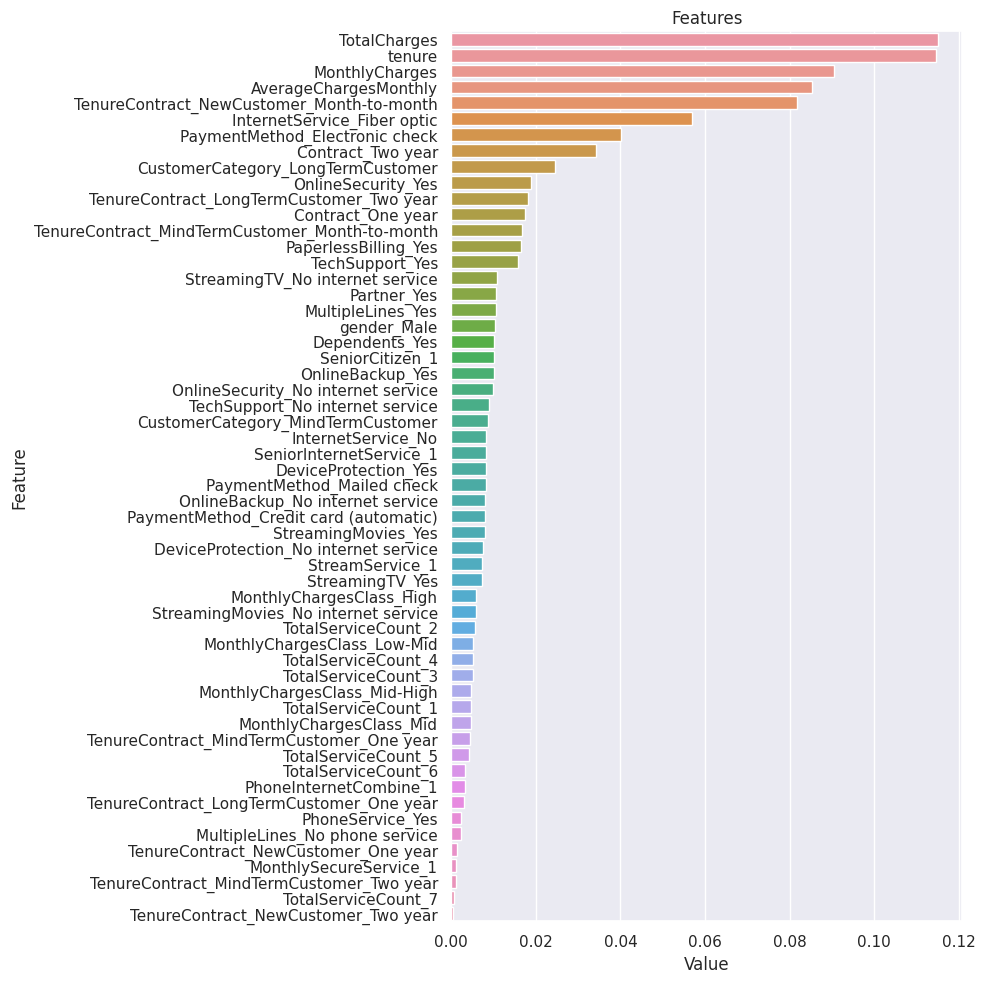

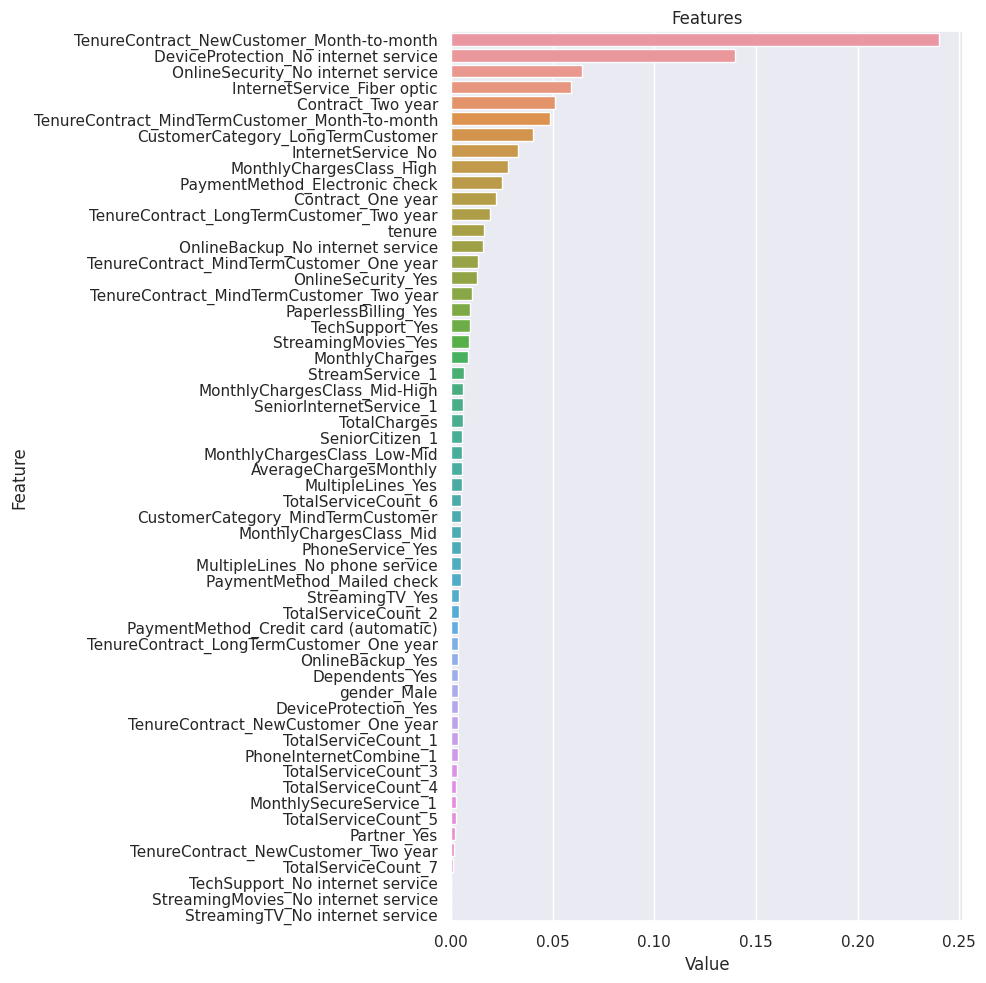

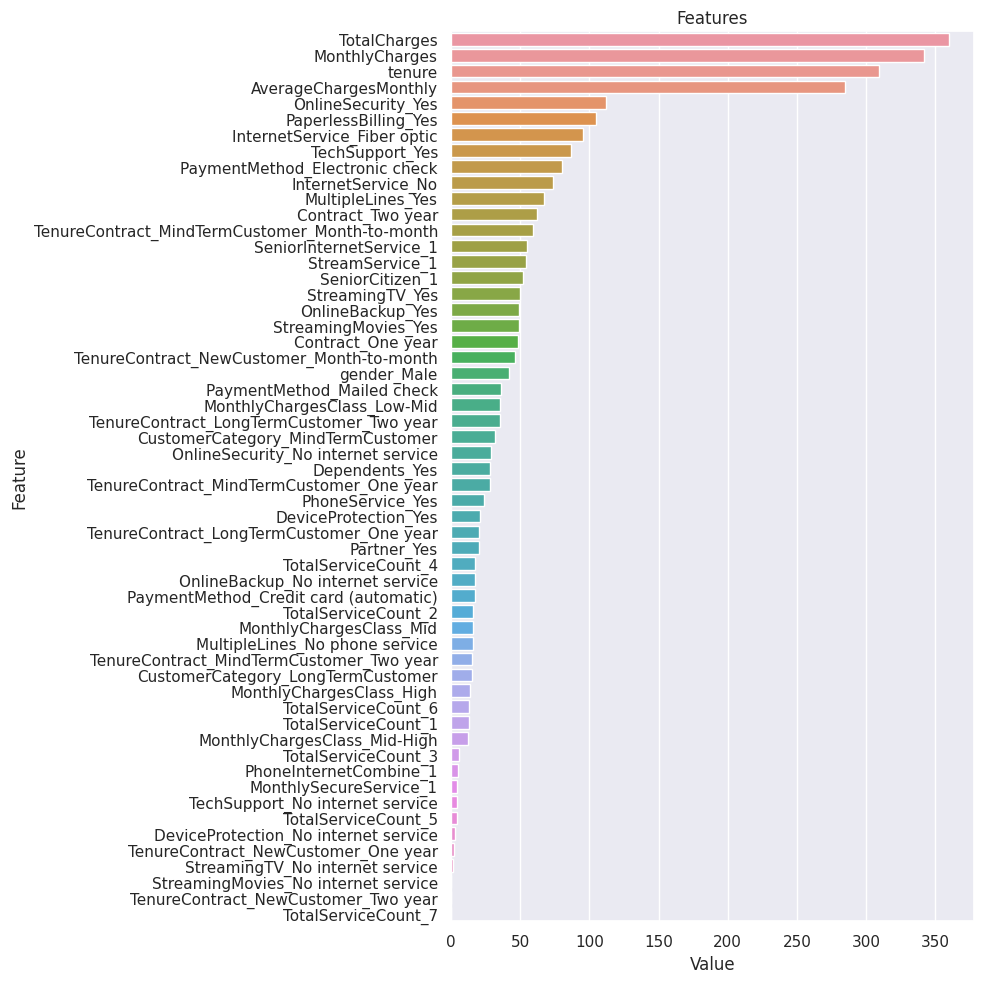

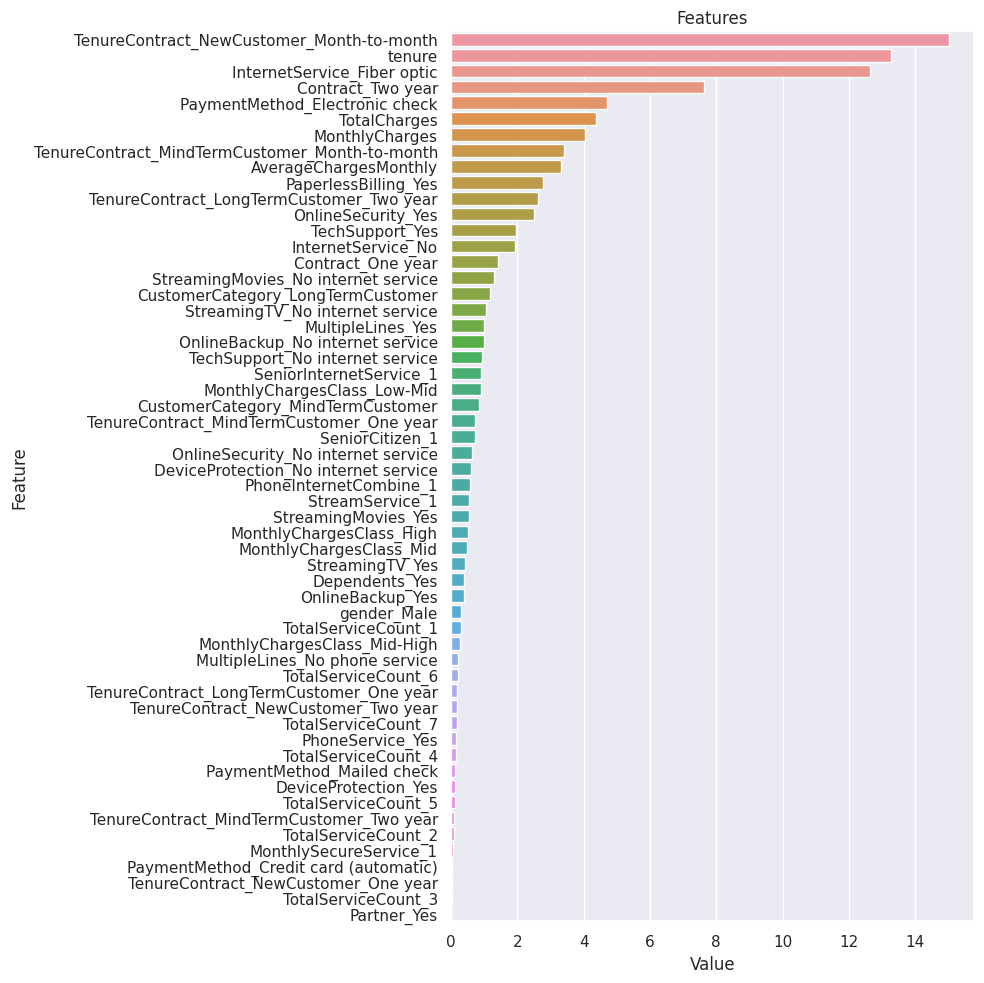

In [30]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)
plot_importance(xgboost_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)
